In [1]:
# Import all the libraries needed
import obspy as obs
import glob
import pygmt
import numpy as np
import os
import utm
import geopandas as gpd
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
client = Client("IRIS")
from obspy import UTCDateTime

In [2]:
# Download the catalog of events near the mainshock

# Mainshock coordinates
lat = 37.2251
lon = 37.0209
# Search radius (deg)
minr = 0.
maxr = 5.
# Search depth (km)
mind = 0.
maxd = 50.
# Search magnitudes
minmag = 0.
maxmag = 8.
# Search dates
ini = "202212010000"
end = "202302281200"

#st = client.get_waveforms("IU", "ANTO", "00", "LHZ", t, t + 24 * 4 * 60 * 60)
#st.plot()
events = client.get_events(starttime=ini,
                   endtime=end,
                   minmagnitude=minmag,
                   maxmagnitude=maxmag,
                   #include_unknown_mag=True, 
                   mindepth=mind, 
                   maxdepth=maxd,
                   latitude=lat, 
                   longitude=lon, 
                   minradius=minr, 
                   maxradius=maxr)  

ev_lat, ev_lon, ev_mag = [], [], []
for ev in events.events:
    ev_lat.append(ev.preferred_origin().latitude)
    ev_lon.append(ev.preferred_origin().longitude)
    ev_mag.append(ev.preferred_magnitude().mag)

# identify mainshock
id_main = np.where(np.asarray(ev_mag) == np.max(ev_mag))[0][0]
print(id_main,np.max(ev_mag))

348 7.8


In [3]:
# read the list of files available (stations to be used)
list_files = glob.glob('v2/*H*Z*')
list_files.sort()

# read the files
sta_names = []
sta_lon = []
sta_lat = []
tp = []
ts = []
s = obs.Stream()
for i in range(len(list_files)):
    file_name = list_files[i]
    t = obs.read(file_name)
    s = s+t    
    sta_lon.append(s[-1].stats.sac.stlo)
    sta_lat.append(s[-1].stats.sac.stla)
    sta_names.append(s[-1].stats.sac.kstnm)
    try:
        tp.append(s[-1].stats.starttime + s[-1].stats.sac.t0)
    except:
        tp.append([])
    try:
        ts.append(s[-1].stats.starttime + s[-1].stats.sac.t1)
    except:
        ts.append([])
    #print(sta_names[-1], sta_lat[-1], sta_lon[-1], tp[-1], ts[-1])


/tmp/ipykernel_69791/2819860323.py:42: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig1.plot(
/tmp/ipykernel_69791/2819860323.py:56: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig1.plot(
/tmp/ipykernel_69791/2819860323.py:71: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig1.plot(
/tmp/ipykernel_69791/2819860323.py:122: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig1.plot(data=data_shp,color="red")
/home/sanchezh/anaconda3/envs/insta/lib/python3.9/site-packages/geopandas/io/file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, 

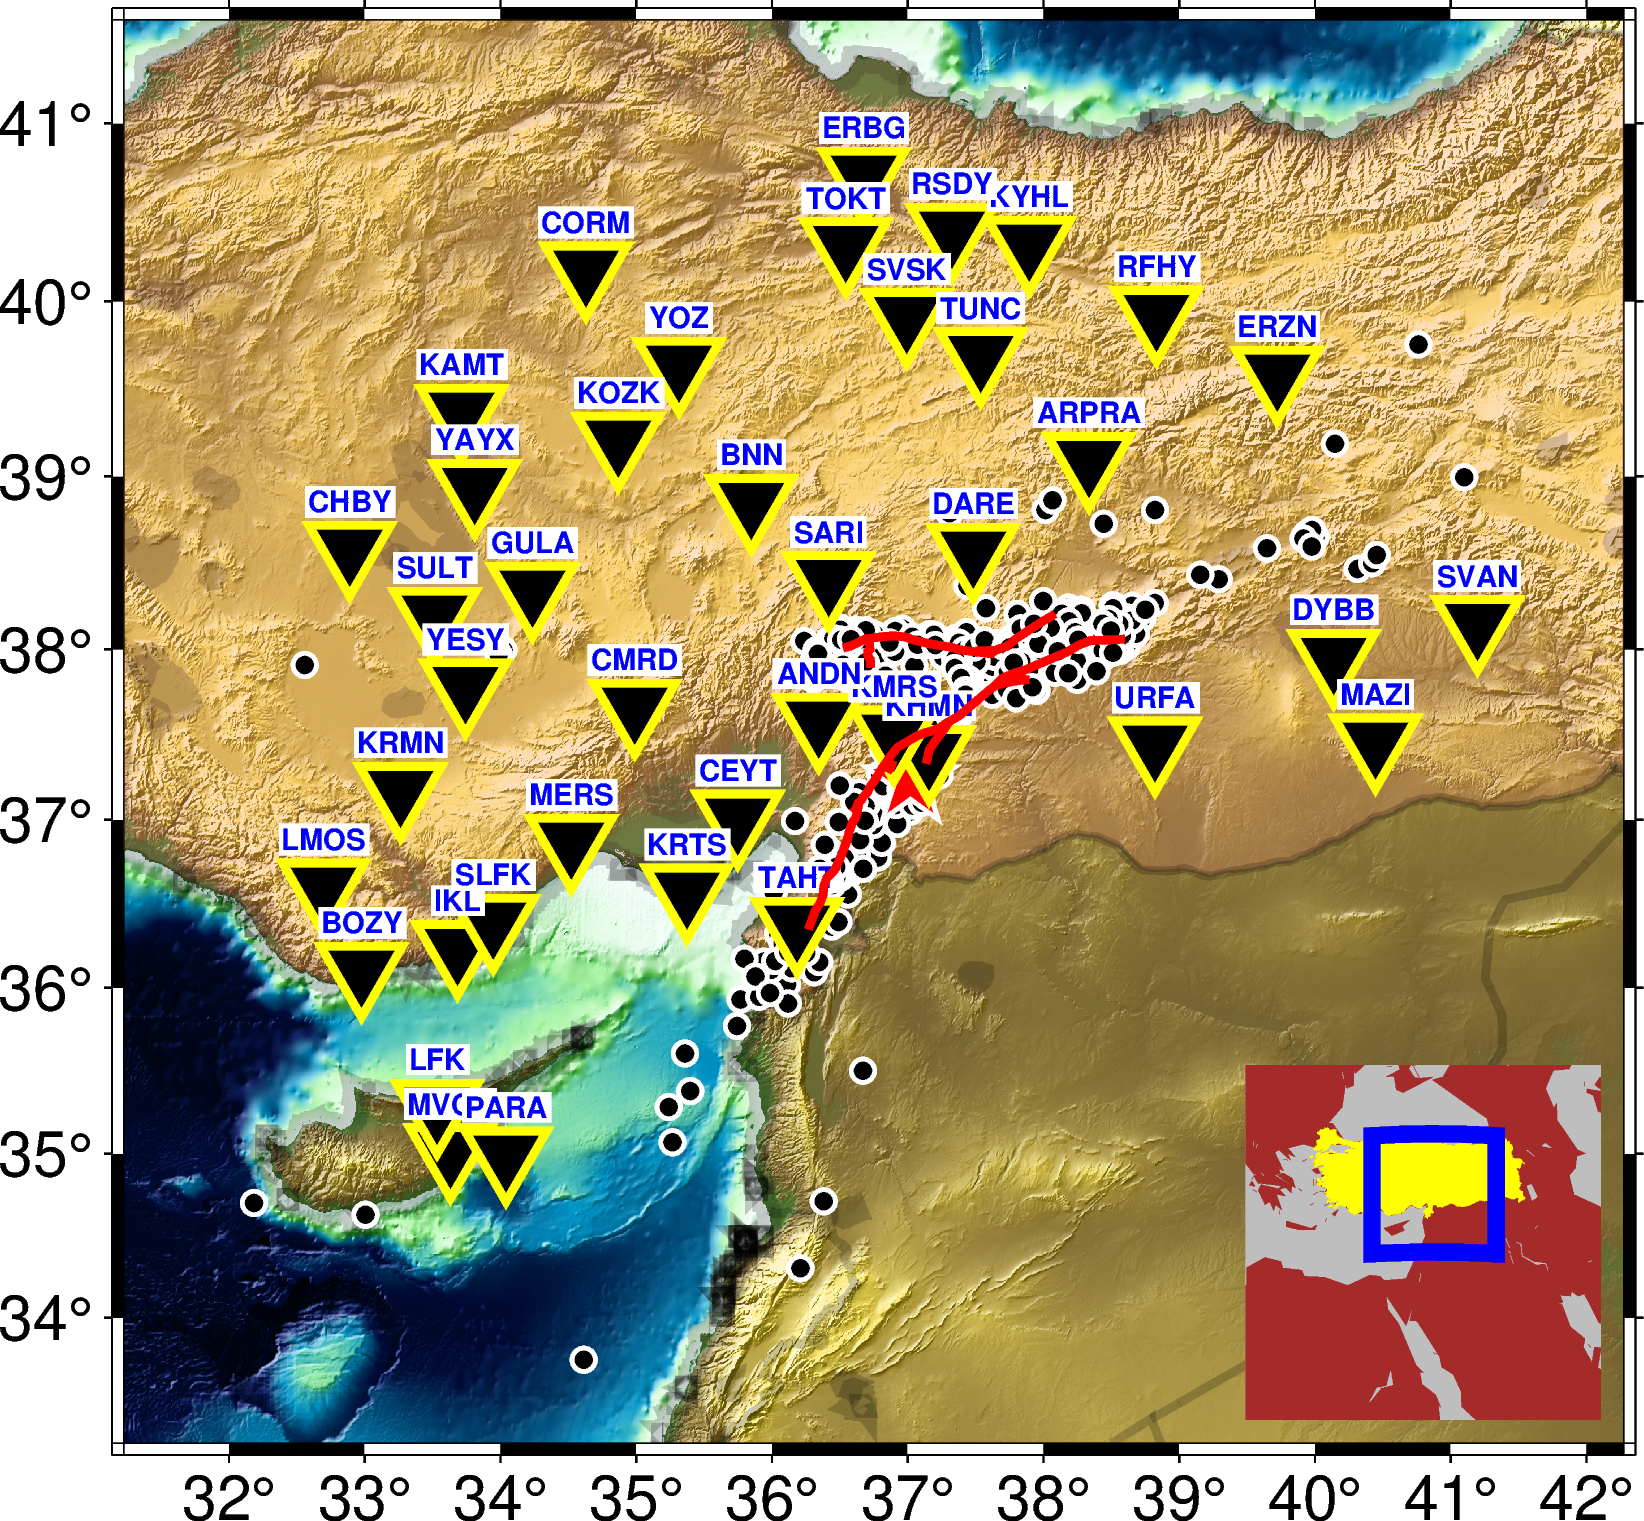

In [4]:
# Plot a map with all the info
# Initialize figure for map
fig1= pygmt.Figure()

# FORMATEA TAMANO DE LETRA
pygmt.config(FORMAT_GEO_MAP='D')  # Use decimal degrees
pygmt.config(FONT='15p')
# Minimum and Maximum coordinates
min_lat = 34.5#np.min(stations_lat)
max_lat = 40.3#np.max(stations_lat)
min_lon = 32.5 #np.min(stations_lon)
max_lon = 41 #np.max(stations_lon)
canvas = (max_lon - min_lon)*0.15

# Plot elevation from grid
fig1.grdimage(
    '@earth_relief_15s',  #DATABASE FORM INTERNET
    region=[min_lon-canvas, max_lon+canvas, min_lat-canvas, max_lat+canvas],
    projection='M5i',
    cmap='relief',
    #frame=['WSne','a0.2f0.2']
    shading=True,
    #transparency=70
    frame=['WSne','ag','1p']
)

# Plot coast lines for the whole world
fig1.coast(
    region=[min_lon-canvas, max_lon+canvas, min_lat-canvas, max_lat+canvas],
    projection='M5i',
    shorelines='5.25p,black', 
    # Nivel de Linea1-4 / Ancho de lapiz , color
    water=None,
    borders="1/2p,black",
    land=None,
    resolution="f",
    dcw="TR+glightred+p0.5p",
    transparency=80,
)

# Plot events
fig1.plot(
    x=ev_lon,
    y=ev_lat,
    style='c0.2',
    projection='M5i',
    color='black',
    pen='1.0p,white',
    #style='c0.005',
    #color='violet',
    #pen='0.001,black',
    label='01/12/22-01/03/23'
)

# Plot main event
fig1.plot(
    x=ev_lon[id_main],
    y=ev_lat[id_main],
    style='a0.8',
    projection='M5i',
    color='red',
    pen='1.0p,white',
    #style='c0.005',
    #color='violet',
    #pen='0.001,black',
    label='Mw 7.8'
)


# Plot events
fig1.plot(
    x=sta_lon,
    y=sta_lat,
    style='i0.8',
    projection='M5i',
    color='black',
    pen='2.0p,yellow',
    #style='c0.005',
    #color='violet',
    #pen='0.001,black',
    label='Stations'
)
station_names = []
for c in range(len(sta_names)):
    station_names.append(sta_names[c])
# Number of stations
n_stations = len(station_names)
for i in range(len(sta_lat)):
    fig1.text(
        x=sta_lon[i],
        y=sta_lat[i],
        text=station_names[i],
        offset="0/0.4",
        font="7p,Helvetica-Bold,blue", 
        fill="white"        
    )
    
rectangle_x = [min_lon-canvas, min_lon-canvas, max_lon+canvas, max_lon+canvas, min_lon-canvas]
rectangle_y = [min_lat-canvas, max_lat+canvas, max_lat+canvas, min_lat-canvas, min_lat-canvas]

with fig1.inset(position="jBR+w3c+o0.2c", margin=0, box="none"):
    # Create a figure in the inset using coast. This example uses the azimuthal
    # orthogonal projection centered at 47E, 20S. The land color is set to
    # "gray" and Madagascar is highlighted in "red3".
    fig1.coast(
        region=[20,60,20,60],
        projection="M1.5i",
        land="brown",
        water="gray",
        dcw="TR+gyellow",
    )
    fig1.plot(x=rectangle_x, y=rectangle_y, projection="M1.5i", pen="4p,blue")

# Load the shape files
fault_shp = os.path.join("fault_data","rupture_james_shapefile.shp")
gdf = gpd.read_file(fault_shp)

all_data = []
all_data.append(gdf[gdf["geometry"] == "LINESTRING"])

for data_shp in all_data:
    fig1.plot(data=data_shp,color="red")
fig1.plot(data=fault_shp, pen="2p,red", label='Traces')

fig1.show()
fig1.savefig('Map.png')

In [52]:
import gemgis as gg
#gdf.head()
#gdf.loc[0].geometry
#gdf.loc[1].geometry.wkt
#gdf_xy = gg.vector.extract_xy(gdf=gdf)
#gdf_xy.head()
#gdf.loc[0].geometry.wkt[:100]
#gdf_xy = gg.vector.extract_xy_linestring(gdf=gdf)
#gdf_xy
#gdf = gpd.GeoDataFrame(geometry=[point, point])
#list(gdf["geometry"][0])

#l = gg.vector.extract_xy_linestrings(gdf=gdf).geometry
#np.asarray(l.array.data)

#gdf.has_z
#list(gdf[0])
#for i in range(8):#len(gdf["geometry"])):
#    a = np.asarray(gdf["geometry"][i])
        
#    l_lon, l_lat = [], []
#    for j in range(len(a)):
#        l_lon.append(a[j][0])
#        l_lat.append(a[j][1])
#    f_lon.append(l_lon)
#    f_lat.append(l_lat)
    

array([<POINT (36.268 36.348)>, <POINT (36.319 36.458)>,
       <POINT (36.357 36.509)>, <POINT (36.377 36.557)>,
       <POINT (36.382 36.604)>, <POINT (36.406 36.656)>,
       <POINT (36.445 36.684)>, <POINT (36.468 36.709)>,
       <POINT (36.49 36.749)>, <POINT (36.52 36.803)>,
       <POINT (36.536 36.843)>, <POINT (36.557 36.878)>,
       <POINT (36.567 36.924)>, <POINT (36.583 36.962)>,
       <POINT (36.595 36.986)>, <POINT (36.615 37.006)>,
       <POINT (36.629 37.041)>, <POINT (36.632 37.066)>,
       <POINT (36.636 37.081)>, <POINT (36.637 37.096)>,
       <POINT (36.658 37.113)>, <POINT (36.67 37.132)>,
       <POINT (36.691 37.149)>, <POINT (36.706 37.163)>,
       <POINT (36.718 37.182)>, <POINT (36.727 37.197)>,
       <POINT (36.756 37.227)>, <POINT (36.797 37.286)>,
       <POINT (36.873 37.374)>, <POINT (36.893 37.395)>,
       <POINT (36.923 37.424)>, <POINT (36.94 37.432)>,
       <POINT (36.989 37.454)>, <POINT (37.024 37.47)>,
       <POINT (37.055 37.485)>, <POI

/tmp/ipykernel_79194/2101433529.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


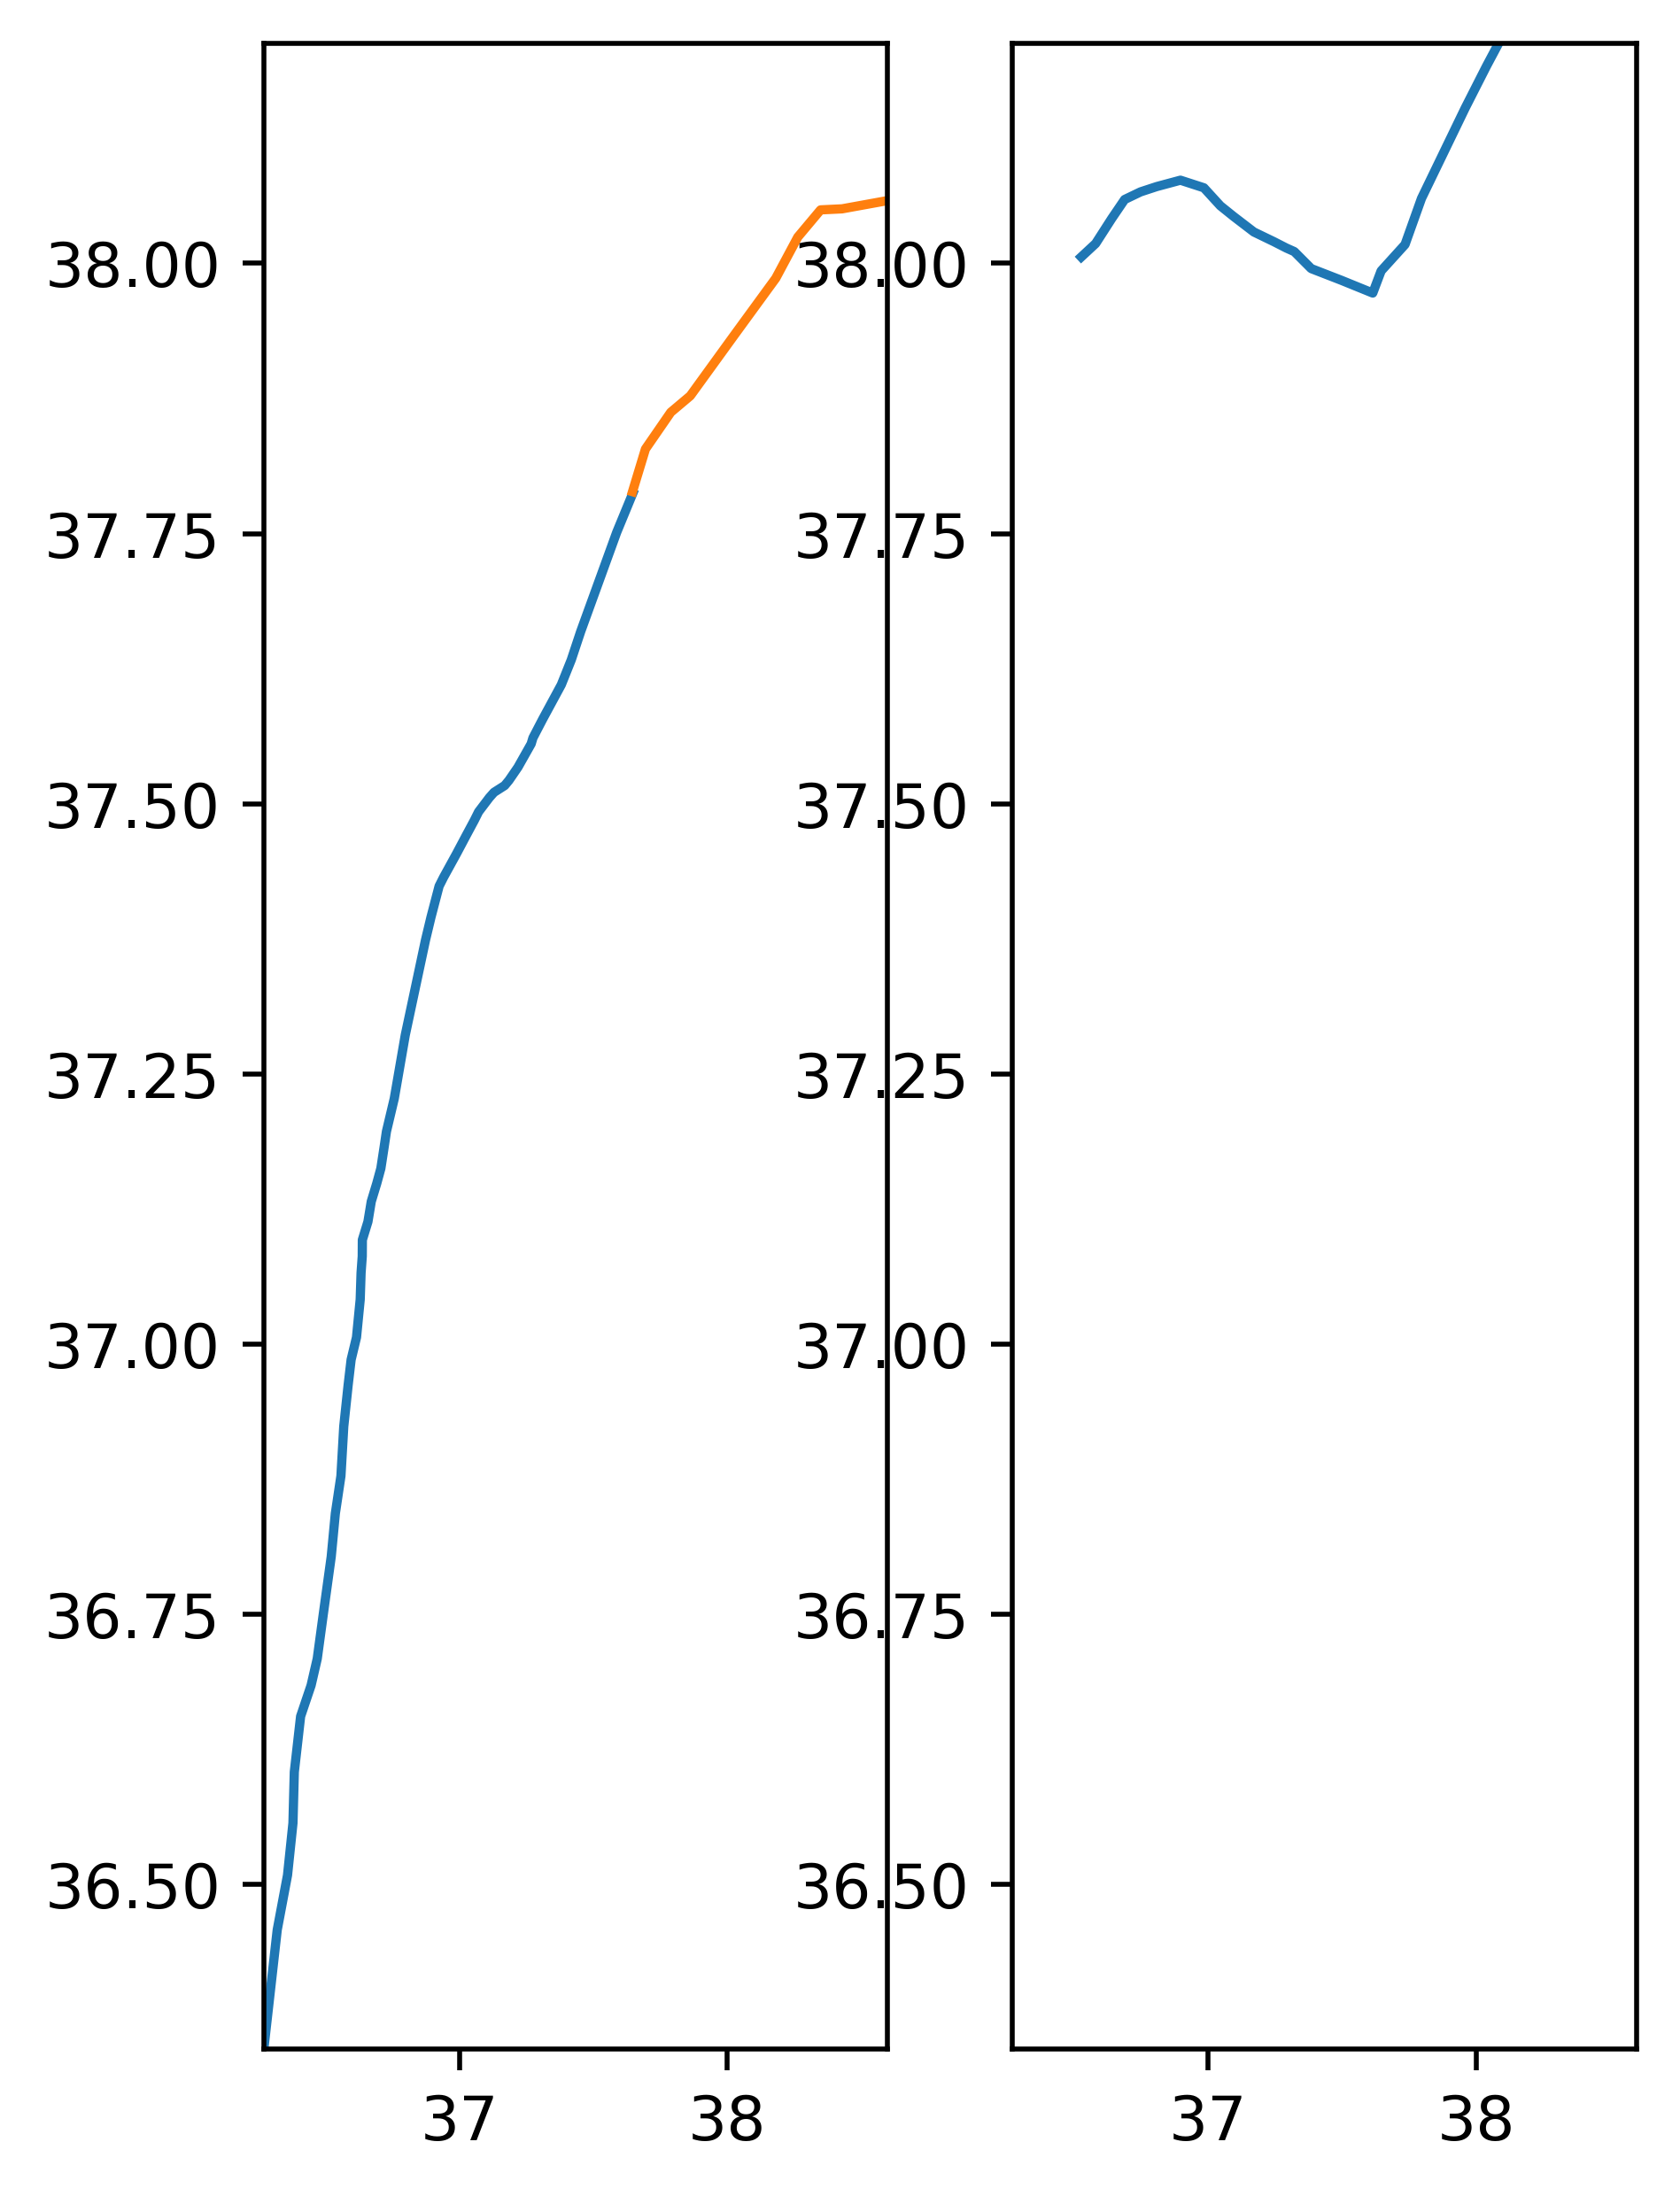

In [66]:
# first fault
fig2, axs2 = plt.subplots(1, 2, dpi=500, figsize=(4, 6), facecolor='white')
ax1 = axs2[0]
ax1.plot(f_lon[0][0:-5],f_lat[0][0:-5])
ax1.plot(f_lon[1],f_lat[1])
ax1.set_xlim([np.min(f_lon[0]), np.max(f_lon[1])])
ax1.set_ylim([np.min(f_lat[0]), np.max(f_lat[2])])

# second fault
ax2 = axs2[1]
ax2.plot(f_lon[2],f_lat[2])
ax2.set_xlim([np.min(f_lon[0]), np.max(f_lon[1])])
ax2.set_ylim([np.min(f_lat[0]), np.max(f_lat[2])])


# FAULTS SEGMENTS BRINGING PROBLEMS
#ax1.plot(f_lon[3],f_lat[3])
#ax1.plot(f_lon[4],f_lat[4])
#ax1.plot(f_lon[5],f_lat[5])
#ax1.plot(f_lon[6],f_lat[6])
#ax1.plot(f_lon[7],f_lat[7])

fig2.show()



In [71]:
# Prepare for creating XY files
f1_lon = f_lon[0][0:-5]
f1_lat = f_lat[0][0:-5]
for j in range(len(f_lon[1])):
    f1_lon.append(f_lon[1][j])
    f1_lat.append(f_lat[1][j])


[36.2684164300655, 36.318645659533402, 36.3571121916899, 36.377401615030202, 36.382450013465601, 36.405993370683397, 36.445147660795499, 36.468123184487702, 36.490121753341398, 36.520352635042002, 36.535712945881798, 36.556643172361902, 36.5672015371266, 36.583367022491103, 36.594642665098299, 36.6148000751419, 36.628625532994299, 36.631875595110202, 36.636281025432098, 36.6366704629515, 36.6575466642865, 36.6699628937928, 36.690640273698001, 36.705808843734701, 36.7179981220985, 36.726609825912199, 36.755931611362897, 36.796997621286401, 36.872516887302602, 36.893190562666703, 36.923430785123003, 36.940349747543202, 36.988663090248302, 37.0242491827089, 37.055170070359402, 37.070901948296203, 37.111307199175897, 37.128442655631801, 37.168327746772199, 37.184256646393401, 37.218023764424302, 37.267342402600804, 37.273950823038703, 37.309931740866404, 37.379969146035101, 37.417221632698002, 37.4524079853553, 37.586894428120701, 37.647008050850701, 37.645901224234599, 37.694249854956901,

In [68]:
print(f1_lon)

[[36.2684164300655, 36.318645659533402, 36.3571121916899, 36.377401615030202, 36.382450013465601, 36.405993370683397, 36.445147660795499, 36.468123184487702, 36.490121753341398, 36.520352635042002, 36.535712945881798, 36.556643172361902, 36.5672015371266, 36.583367022491103, 36.594642665098299, 36.6148000751419, 36.628625532994299, 36.631875595110202, 36.636281025432098, 36.6366704629515, 36.6575466642865, 36.6699628937928, 36.690640273698001, 36.705808843734701, 36.7179981220985, 36.726609825912199, 36.755931611362897, 36.796997621286401, 36.872516887302602, 36.893190562666703, 36.923430785123003, 36.940349747543202, 36.988663090248302, 37.0242491827089, 37.055170070359402, 37.070901948296203, 37.111307199175897, 37.128442655631801, 37.168327746772199, 37.184256646393401, 37.218023764424302, 37.267342402600804, 37.273950823038703, 37.309931740866404, 37.379969146035101, 37.417221632698002, 37.4524079853553, 37.586894428120701, 37.647008050850701], [37.645901224234599, 37.6942498549569